## Sampling: Emcee Hammer MCMC

This example shows you how to perform Bayesian inference on a time series, using [emcee hammer MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/emcee_hammer_mcmc.html) as introduced in [1].

It follows on from the [first sampling example](./first-example.ipynb).

[1] "emcee: The MCMC Hammer", Daniel Foreman-Mackey, David W. Hogg,
    Dustin Lang, Jonathan Goodman, 2013, arXiv, 
    https://arxiv.org/pdf/1202.3665.pdf

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [real_parameters * (1 + 0.1 * np.random.rand()) for i in range(num_chains)]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.EmceeHammerMCMC)

# Add stopping criterion
mcmc.set_max_iterations(6000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(500)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Emcee Hammer MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     4       0:00.0
2     5       0:00.0
3     6       0:00.0
500   503     0:00.1
1000  1003    0:00.1
1500  1503    0:00.2
2000  2003    0:00.3
2500  2503    0:00.3
3000  3003    0:00.4
3500  3503    0:00.4
4000  4003    0:00.5
4500  4503    0:00.6
5000  5003    0:00.6
5500  5503    0:00.7
6000  6002    0:00.7
Halting: Maximum number of iterations (6000) reached.
Done!


param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  -----  --------------
r        0.02    0.00    0.01    0.01    0.02    0.02    0.02     1.04    86.89  117.12
k        499.70  0.53    498.66  499.33  499.71  500.08  500.66   1.05    82.31  110.95
sigma    10.00   0.01    9.99    10.00   10.00   10.01   10.02    1.03    87.37  117.77


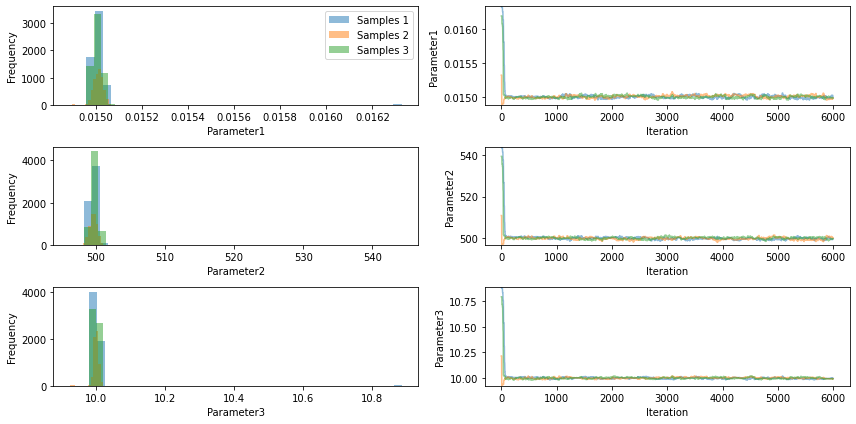

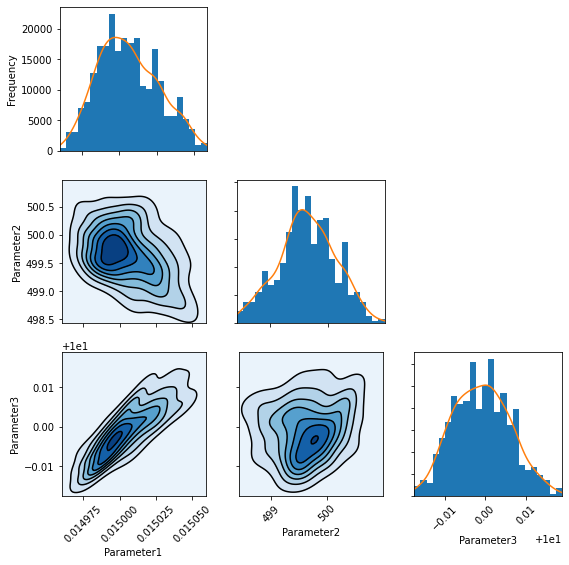

In [2]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:, :]

# Apply thinning
chains = chains[:, ::10]

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['r', 'k', 'sigma'])
print(results)

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()